# Optimism Proposer - L1 transaction analysis

#### Maria Silva, February 2024

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Data preparation 

In [2]:
raw_df = pd.read_csv("../data/op-proposer-txs-6-months.csv")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4426 entries, 0 to 4425
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hash                   4426 non-null   object 
 1   block_timestamp        4426 non-null   object 
 2   gas_used               4426 non-null   int64  
 3   gas_used_final         4426 non-null   int64  
 4   gas_price_gwei         4426 non-null   float64
 5   gas_price_final_gwei   4426 non-null   float64
 6   max_priority_fee_gwei  4426 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 242.2+ KB


In [3]:
prop_df = raw_df.copy()
prop_df["timestamp"] = pd.to_datetime(prop_df['block_timestamp'])
prop_df['gas_estimation_err'] = prop_df['gas_used']-prop_df['gas_used_final']
prop_df['gas_limit_thou'] = prop_df['gas_used']/1000
prop_df['gas_used_thou'] = prop_df['gas_used_final']/1000
prop_df["post_freq_min"]= prop_df["timestamp"].diff().dt.seconds/60

cols = ["timestamp", "gas_limit_thou", "gas_used_thou","gas_estimation_err", 
        "post_freq_min", "gas_price_final_gwei", "max_priority_fee_gwei"]
prop_df = prop_df[cols]
prop_df.head()

,timestamp,gas_limit_thou,gas_used_thou,gas_estimation_err,post_freq_min,gas_price_final_gwei,max_priority_fee_gwei
0,2023-08-16 00:56:59+00:00,87.758,86.850,908,NaN,22.413492,0.032960
1,2023-08-16 01:54:35+00:00,87.770,86.862,908,57.6,18.083497,0.026925
2,2023-08-16 02:52:23+00:00,87.770,86.862,908,57.8,19.215619,0.026925
3,2023-08-16 03:49:35+00:00,87.770,86.862,908,57.2,20.212972,0.026925
4,2023-08-16 04:53:35+00:00,87.758,86.850,908,64.0,20.689198,0.023353


## Gas usage

In [4]:
temp_df = (
    prop_df
    [["gas_limit_thou", "gas_used_thou", "gas_estimation_err"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
gas_limit_thou,87.77,0.01,-0.11,0.00
gas_used_thou,86.86,0.01,-2.01,0.00
gas_estimation_err,909.18,4.71,3.75,0.01


In [5]:
(prop_df
 [["gas_limit_thou", "gas_used_thou", "gas_estimation_err"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
gas_limit_thou,87.72,87.77,87.77,87.77,87.79
gas_used_thou,86.81,86.86,86.86,86.86,86.86
gas_estimation_err,908.00,908.00,908.00,908.00,928.00


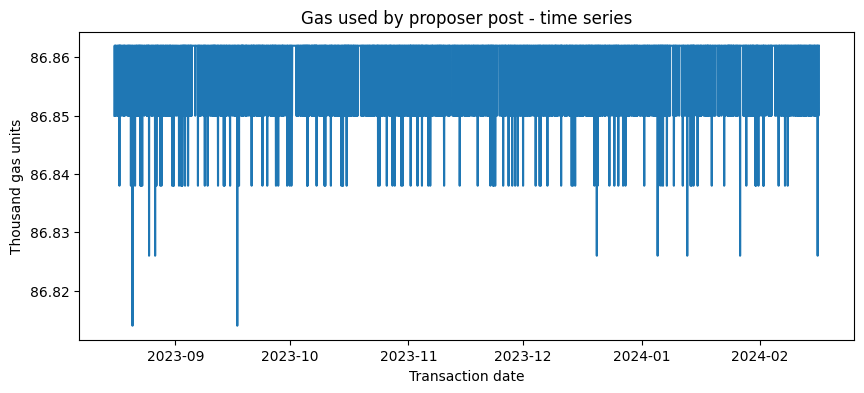

In [6]:
plt.figure(figsize=(10,4))
sns.lineplot(data=prop_df, x='timestamp', y='gas_used_thou')
plt.title("Gas used by proposer post - time series")
plt.xlabel('Transaction date')
plt.ylabel('Thousand gas units')
plt.show()

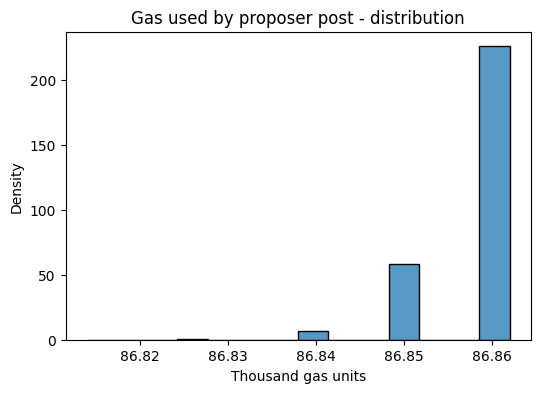

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(data=prop_df, x='gas_used_thou', stat='density')
plt.title("Gas used by proposer post - distribution")
plt.xlabel('Thousand gas units')
plt.ylabel('Density')
plt.show()

## Posting frequency

In [8]:
temp_df = (
    prop_df
    [["post_freq_min"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
post_freq_min,60.0,3.14,0.48,0.05


In [9]:
(prop_df
 [["post_freq_min"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
post_freq_min,50.8,57.6,57.8,64.0,70.2


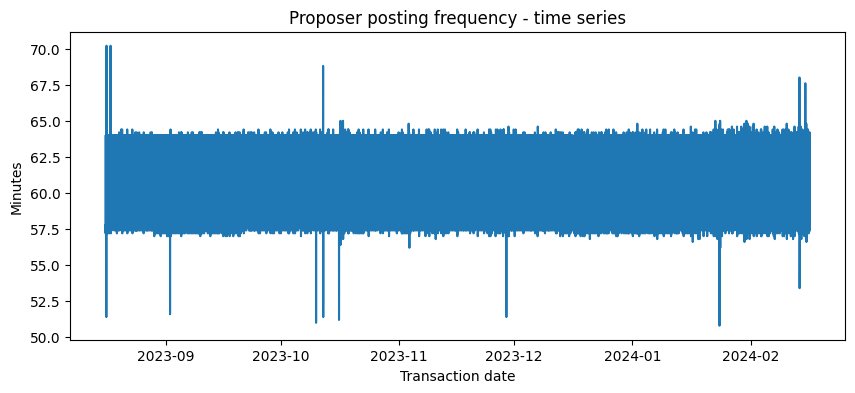

In [10]:
plt.figure(figsize=(10,4))
sns.lineplot(data=prop_df, x='timestamp', y='post_freq_min')
plt.title("Proposer posting frequency - time series")
plt.xlabel('Transaction date')
plt.ylabel('Minutes')
plt.show()

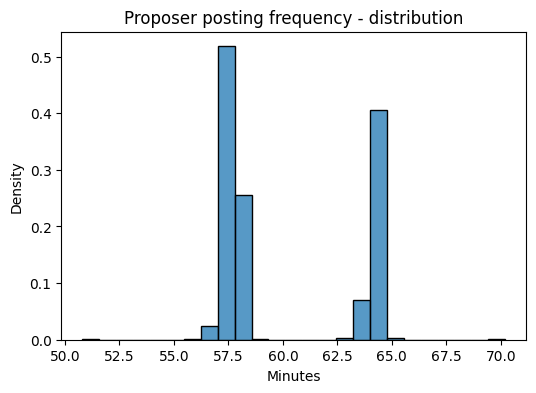

In [11]:
plt.figure(figsize=(6,4))
sns.histplot(data=prop_df, x='post_freq_min', stat='density')
plt.title("Proposer posting frequency - distribution")
plt.xlabel('Minutes')
plt.ylabel('Density')
plt.show()

## L1 gas prices - priority fees

In [12]:
temp_df = (
    prop_df
    [["max_priority_fee_gwei"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
max_priority_fee_gwei,0.03,0.09,10.26,3.0


In [13]:
(prop_df
 [["max_priority_fee_gwei"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
max_priority_fee_gwei,0.0,0.01,0.01,0.03,1.0


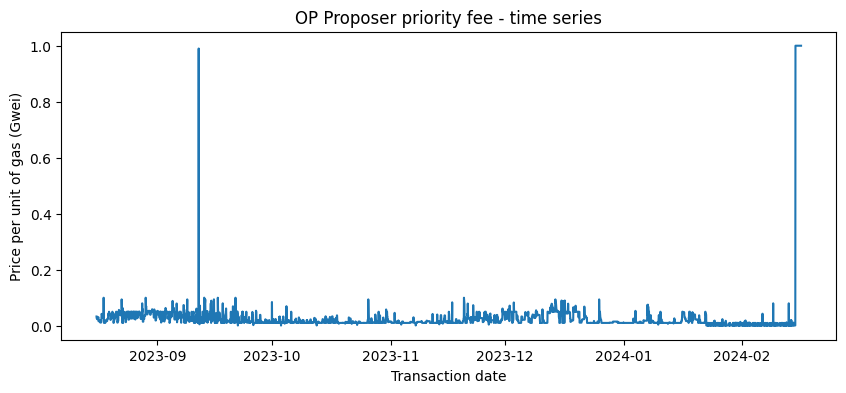

In [14]:
plt.figure(figsize=(10,4))
sns.lineplot(data=prop_df, x='timestamp', y='max_priority_fee_gwei')
plt.title("OP Proposer priority fee - time series")
plt.xlabel('Transaction date')
plt.ylabel('Price per unit of gas (Gwei)')
plt.show()

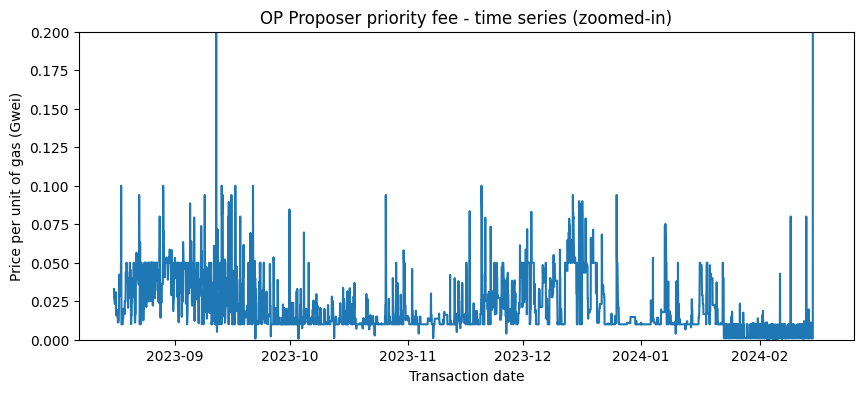

In [15]:
plt.figure(figsize=(10,4))
sns.lineplot(data=prop_df, x='timestamp', y='max_priority_fee_gwei')
plt.title("OP Proposer priority fee - time series (zoomed-in)")
plt.xlabel('Transaction date')
plt.ylabel('Price per unit of gas (Gwei)')
plt.ylim(0,0.2)
plt.show()

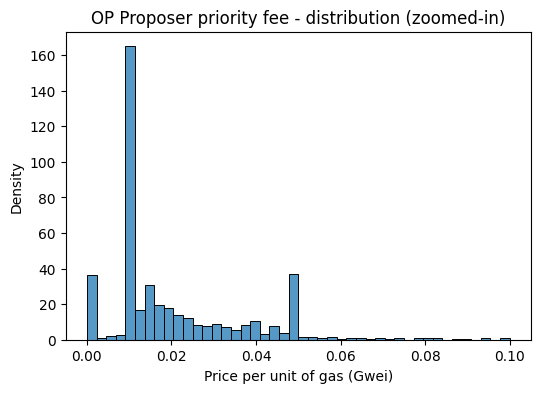

In [16]:
temp = prop_df[prop_df["max_priority_fee_gwei"]<0.2]
plt.figure(figsize=(6,4))
sns.histplot(data=temp, x='max_priority_fee_gwei', stat='density')
plt.title("OP Proposer priority fee - distribution (zoomed-in)")
plt.xlabel('Price per unit of gas (Gwei)')
plt.ylabel('Density')
plt.show()

## L1 gas prices - total fees

In [17]:
temp_df = (
    prop_df
    [["gas_price_final_gwei"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
gas_price_final_gwei,23.91,18.03,5.54,0.75


In [18]:
(prop_df
 [["gas_price_final_gwei"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
gas_price_final_gwei,4.77,11.89,19.66,31.2,458.99


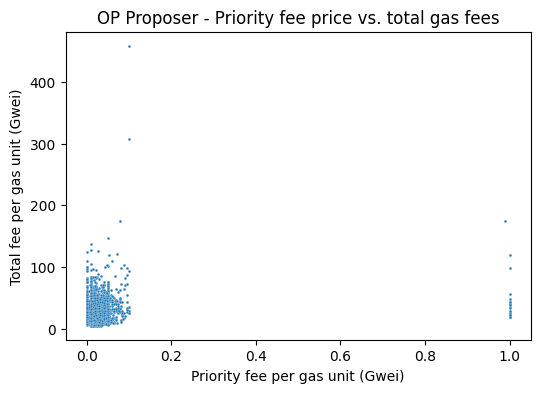

In [19]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=prop_df, x='max_priority_fee_gwei', y='gas_price_final_gwei', s=4)
plt.title("OP Proposer - Priority fee price vs. total gas fees")
plt.xlabel('Priority fee per gas unit (Gwei)')
plt.ylabel('Total fee per gas unit (Gwei)')
plt.show()

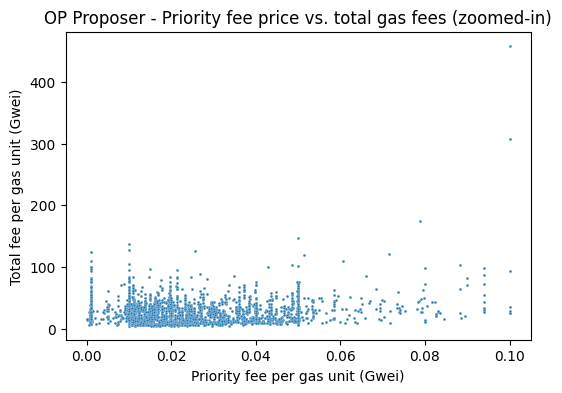

In [20]:
temp = prop_df[prop_df["max_priority_fee_gwei"]<0.3]
plt.figure(figsize=(6,4))
sns.scatterplot(data=temp, x='max_priority_fee_gwei', y='gas_price_final_gwei', s=4)
plt.title("OP Proposer - Priority fee price vs. total gas fees (zoomed-in)")
plt.xlabel('Priority fee per gas unit (Gwei)')
plt.ylabel('Total fee per gas unit (Gwei)')
plt.show()